In [7]:
import torch
print("Pytorch version: " + torch.__version__)
print("ROCM HIP version: " + torch.version.hip)
torch.cuda.set_device('cuda:0')

from unyt import *
from synthesizer.parametric import SFH

%load_ext autoreload
%autoreload 2

Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import harmonic as hm
from harmonic.model import RealNVPModel

In [17]:
from harmonic.model import ModifiedGaussianMixtureModel

In [ ]:
sed_path = 'Yggdrasil/PopIII.1_fcov_1_SFR_10M_yr_Spectra'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re

def load_seds_from_file(filename):
    """
    Load multiple SED datasets from a text file.
    
    Parameters:
    -----------
    filename : str
        Path to the text file containing multiple SED datasets
        
    Returns:
    --------
    list
        List of dictionaries, each containing metadata and wavelength/flux data for one SED
    """
    seds = []
    current_metadata = {}
    current_wavelength = []
    current_flux = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        
        in_data_section = False
        
        for i, line in enumerate(lines):
            line = line.strip()
            
            # Skip empty lines
            if not line:
                continue
            
            # Check if this is the start of a new SED section
            if "Age (Myr):" in line and in_data_section:
                # Save the current SED data before starting a new one
                if current_wavelength and current_flux:
                    seds.append({
                        "metadata": current_metadata.copy(),
                        "wavelength": np.array(current_wavelength),
                        "flux": np.array(current_flux)
                    })
                    
                # Reset for the new SED
                current_metadata = {}
                current_wavelength = []
                current_flux = []
                in_data_section = False
            
            # Process data section
            if in_data_section:
                # Handle potential formatting issues in the data
                line = line.replace("'", "").strip()
                parts = re.split(r'\s+', line)
                
                if len(parts) >= 2:
                    try:
                        wl = float(parts[0])
                        fl = float(parts[1])
                        current_wavelength.append(wl)
                        current_flux.append(fl)
                    except ValueError:
                        # Skip lines that can't be parsed as numbers
                        pass
            
            # Parse metadata
            elif "Wavelength (AA)" in line and "Flux" in line:
                in_data_section = True
            elif ":" in line:
                key, value = line.split(":", 1)
                current_metadata[key.strip()] = value.strip()
            elif "Wavelength unit" in line:
                parts = line.split(":", 1) if ":" in line else line.split()
                if len(parts) > 1:
                    current_metadata["Wavelength unit"] = parts[1].strip() if ":" in line else parts[2].strip()
            elif "Energy unit" in line:
                parts = line.split(":", 1) if ":" in line else line.split()
                if len(parts) > 1:
                    current_metadata["Energy unit"] = parts[1].strip() if ":" in line else parts[2].strip()
    
    # Don't forget to add the last SED
    if current_wavelength and current_flux:
        seds.append({
            "metadata": current_metadata,
            "wavelength": np.array(current_wavelength),
            "flux": np.array(current_flux)
        })

    
    for i, sed in enumerate(seds):
        # Convert wavelength and flux to unyt arrays with appropriate units
        sed["wavelength"] = unyt_array(sed["wavelength"], units=Angstrom)
        sed["flux"] = unyt_array(sed["flux"], units=erg / (s * Angstrom))
        # convert to fnu (erg/s*Hz)
        sed["flux"] = (sed["flux"] * sed["wavelength"]**2/ (2.99792458e9  * m/s)).to(erg / (s * Hz))
        sed['metadata']['Energy unit'] = 'erg/s/Hz'

    
    return seds

def load_seds_from_files(filenames):
    """
    Load multiple SED datasets from a list of text files.
    
    Parameters:
    -----------
    filenames : list
        List of paths to text files containing SED datasets
        
    Returns:
    --------
    list
        List of dictionaries, each containing metadata and wavelength/flux data for one SED
    """
    seds = []
    
    for filename in filenames:
        seds.extend(load_seds_from_file(filename))
    
    return seds

def plot_sed(sed_data, ax=None, label=None):
    """
    Plot a single SED dataset.
    
    Parameters:
    -----------
    sed_data : dict
        Dictionary containing wavelength and flux data
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, a new figure is created.
    label : str, optional
        Label for the plot legend
    
    Returns:
    --------
    matplotlib.axes.Axes
        The axes on which the plot was drawn
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a label if not provided
    if label is None and "Age (Myr)" in sed_data["metadata"]:
        label = f"Age: {float(sed_data['metadata']['Age (Myr)']):.4g} Myr"
    
    ax.loglog(sed_data["wavelength"], sed_data["flux"], label=label)
    
    ax.set_xlabel(f'Wavelength ({sed_data["metadata"].get("Wavelength unit", "AA")})')
    ax.set_ylabel(f'Flux ({sed_data["metadata"].get("Energy unit", "erg")}')
    ax.set_title('Spectral Energy Distribution')
    ax.grid(True, which="both", ls="--", alpha=0.3)
    
    if label:
        ax.legend()
    
    return ax

def plot_multiple_seds(seds_data, max_seds=None):
    """
    Create a plot comparing multiple SEDs.
    
    Parameters:
    -----------
    seds_data : list
        List of SED data dictionaries
    max_seds : int, optional
        Maximum number of SEDs to plot. If None, all SEDs are plotted.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure containing the plot
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Limit the number of SEDs to plot if specified
    if max_seds is not None:
        seds_to_plot = seds_data[:max_seds]
    else:
        seds_to_plot = seds_data
    
    for i, sed in enumerate(seds_to_plot):
        age = float(sed["metadata"].get("Age (Myr)", f"SED {i+1}"))
        label = f"Age: {age:.4g} Myr"
        plot_sed(sed, ax=ax, label=label)
    
    plt.tight_layout()
    return fig

def print_sed_summary(sed_data, index=None):
    """
    Print a summary of SED metadata and data statistics.
    
    Parameters:
    -----------
    sed_data : dict
        Dictionary containing SED metadata and data
    index : int, optional
        Index of the SED (for display purposes)
    """
    if index is not None:
        print(f"\nSED #{index+1}:")
    else:
        print("\nSED Summary:")
    
    # Print metadata
    for key, value in sed_data["metadata"].items():
        print(f"  {key}: {value}")
    
    # Print data statistics
    print(f"\n  Data points: {len(sed_data['wavelength'])}")
    print(f"  Wavelength range: {sed_data['wavelength'].min()} - {sed_data['wavelength'].max()} {sed_data['metadata'].get('Wavelength unit', 'AA')}")
    print(f"  Flux range: {sed_data['flux'].min():.3e} - {sed_data['flux'].max():.3e} {sed_data['metadata'].get('Energy unit', 'erg')}")

# Example usage
if __name__ == "__main__":
    # Replace 'your_sed_file.txt' with the path to your file
    seds = load_seds_from_file(sed_path)
    
    print(f"Loaded {len(seds)} SED datasets from file.")
    
    # Print summary of first few SEDs
    max_display = min(3, len(seds))
    for i in range(max_display):
        print_sed_summary(seds[i], index=i)
    
    if len(seds) > max_display:
        print(f"\n...and {len(seds) - max_display} more SED datasets.")
    
    # Plot all SEDs on the same graph (limit to 10 for readability)
    max_plot = min(10, len(seds))
    if max_plot < len(seds):
        print(f"\nPlotting first {max_plot} of {len(seds)} SEDs...")
    
    fig = plot_multiple_seds(seds, max_seds=max_plot)
    plt.show()
    

NameError: name 'sed_path' is not defined

In [ ]:
# do we even need to give muv? Or is shape enough?

# Can simply give normalized photometry. 
# If we give muv it will be in log10(nJy) units. 
# Giving normalized photometry allows us to pass in negative photometry better


features = filter_codes + \
            ["JWST/NIRCam.F115W-JWST/NIRCam.F150W", "JWST/NIRCam.F150W-JWST/NIRCam.F277W", "JWST/NIRCam.F277W-JWST/NIRCam.F444W"] + \
            ['muv', 'z']


In [ ]:
def compute_photometry_from_sed(sed_data, filterset, redshift, supress_lya=False, plot=False):
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')

    norm_arr = np.full(len(sed_data), np.nan)
    phot_data_arr = np.full((len(sed_data), len(filterset)), np.nan)

    for pos, sed_i in enumerate(sed_data):
        if supress_lya:
            # Find pixel closest to 1216 and set to next pixel
            index = np.argmin(np.abs(sed_i['wavelength'] - 1216 * Angstrom))
            sed_i['flux'][index] = sed_i['flux'][index + 1]
           
        sed = Sed(lam = sed_i['wavelength'], lnu = sed_i['flux'])
        sed.get_fnu(cosmo=cosmo, z = redshift, igm=Inoue14)
        phot = sed.get_photo_fnu(filters=filterset)

        muv = sed.get_lnu_at_lam(15000 * Angstrom)
        # muv is rest-frame luminosity at 15000 Angstrom. Apply cosmological dimming
        # to get apparent magnitude

        muv = (muv * (1 + redshift)**2 / (4 * np.pi * (cosmo.luminosity_distance(redshift).to(u.m).value *m)**2)).to(nJy)

        phot_data = phot.photo_fnu

        norm_arr[pos] = np.log10(muv.value)

        phot_data_arr[pos] = phot_data.value

        if plot:
            wav = phot.filters.pivot_lams
            ax.plot(wav, phot_data/muv, label=f"z={redshift:.2f}")
            ax.set_title(f"SED Photometry (z={redshift:.2f})")
            ax.set_xlabel("Wavelength (Angstrom)")
            ax.set_ylabel("Photometry (normalized to 15000 Angstrom)")
        
    return phot_data_arr, norm_arr


def generate_feature_array(feature_names, seds, redshifts, filterset, supress_lya=False):
    
    feature_array = np.full((len(seds)*len(redshifts), len(feature_names)), np.nan)

    sum_indexes = []
    opp_types = []

    for feature_name in feature_names:
        if '-' in feature_name:
            filters = feature_name.split('-')
            sum_indexes.append([filter_codes.index(filters[0]), filter_codes.index(filters[1])])
            opp_types.append(np.subtract)
        elif '+' in feature_name:
            filters = feature_name.split('+')
            sum_indexes.append([filter_codes.index(filters[0]), filter_codes.index(filters[1])])
            opp_types.append(np.add)
        else:
            pass
            
    for i, redshift in enumerate(redshifts):
        for j, sed in enumerate(seds):
            phot_data_arr, norm_arr = compute_photometry_from_sed([sed], filterset, redshift, supress_lya=supress_lya)
            colors = []
            for k, sum_index in enumerate(sum_indexes):
                colors.append(opp_types[k](phot_data_arr[0][sum_index[0]], phot_data_arr[0][sum_index[1]]))
                
            feature_array[i * len(seds) + j] = np.concatenate((phot_data_arr[0], colors, [norm_arr[0], redshift]))

    return feature_array

redshifts = np.arange(6, 15, 0.1)

feature_array = generate_feature_array(features, seds, redshifts, filterset, supress_lya=True)

In [ ]:
# Split into train/test and build loaders
test_split = 0.1
n_samples = len(feature_array)

# Model 1
mask1 = np.random.rand(n_samples) > test_split
x1_train, x1_test = feature_array[mask1], feature_array[~mask1]
theta1_train, theta1_test = theta1[mask1], theta1[~mask1]


# Build loaders
loader1_train = NumpyLoader(x1_train, theta1_train)
loader1_test = NumpyLoader(x1_test, theta1_test)


In [ ]:
# Training scripts to train NPE/NLE with LtU-ILI
def train_nde(loader, prior_mu, engine='NLE'):
    # define a prior
    prior = ili.utils.IndependentNormal(
        loc=prior_mu,
        scale=1*np.ones(Ndim),
        device=device
    )
    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_sbi(
            engine=engine, model='mdn', hidden_features=50, num_components=4),
    ]
    # define training arguments
    train_args = {
        'training_batch_size': 64,
        'learning_rate': 5e-4
    }
    # initialize the trainer
    runner = InferenceRunner.load(
        backend='sbi',
        engine=engine,
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args,
    )
    # train the model
    posterior_ensemble, summaries = runner(loader=loader)
    return posterior_ensemble, summaries

In [ ]:
# Train Neural Likelihood Estimation
nle1, summ_nle1 = train_nde(loader1_train, mu1, 'NLE')
nle2, summ_nle2 = train_nde(loader2_train, mu2, 'NLE')

# Train Neural Posterior Estimation
npe1, summ_npe1 = train_nde(loader1_train, mu1, 'NPE')
npe2, summ_npe2 = train_nde(loader2_train, mu2, 'NPE')

[1.0000e+07 6.3250e+08 1.2550e+09 1.8775e+09 2.5000e+09] [1.000e+07 2.575e+08 5.050e+08 7.525e+08 1.000e+09]


/tmp/ipykernel_298464/2662500519.py:51: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  tau, t0 = fsolve(lognorm_equations, (tau_guess, t0_guess),
/tmp/ipykernel_298464/2662500519.py:59: RuntimeWarning: invalid value encountered in divide
  sfr = sfr / sfr.max()


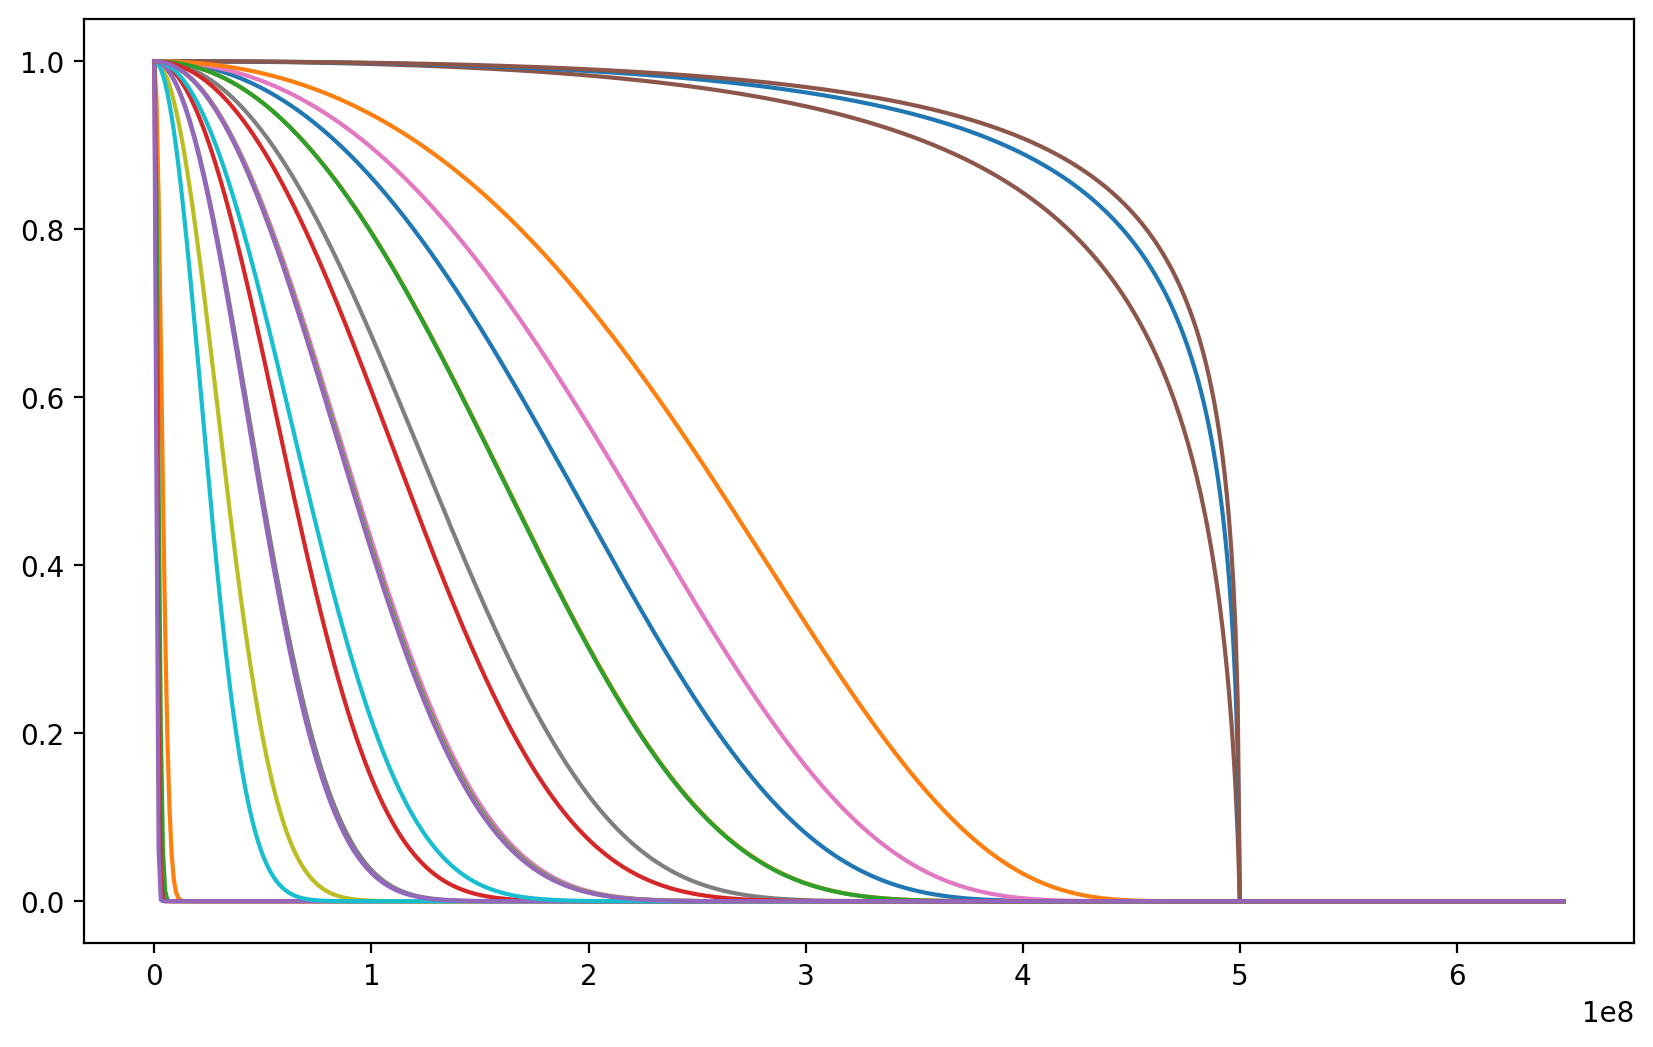

In [10]:
from scipy.optimize import fsolve
def lognorm_equations(p, consts):
    """ Equations for finding the tau and T0 for a lognormal SFH given
    some tmax and FWHM. Needed to transform variables. """

    tau_solve, T0_solve = p

    xmax, h = consts

    tau = np.exp(T0_solve - tau_solve**2) - xmax
    t0 = xmax*(np.exp(0.5*np.sqrt(8*np.log(2)*tau_solve**2))
               - np.exp(-0.5*np.sqrt(8*np.log(2)*tau_solve**2))) - h

    return (tau, t0)


tmaxes = np.linspace(10, 2500, 5) * Myr 
tmaxes = tmaxes.to(yr).to_value()

FWHMs = np.linspace(10, 1000, 5) * Myr
FWHMs = FWHMs.to(yr).to_value()

print(tmaxes, FWHMs)


# Create a grid of tmax and FWHM values

tmax_grid, FWHM_grid = np.meshgrid(tmaxes, FWHMs)
# Flatten the grid for easier processing
tmax_flat = tmax_grid.flatten()
FWHM_flat = FWHM_grid.flatten() 

# Create a list to store the results
results = []
# Loop through the grid and calculate tau and T0 for each combination


fig, ax = plt.subplots(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')

max_age=500*Myr

for tmax, fwhm in zip(tmax_flat, FWHM_flat):
    # Define the constants for the equations
    consts = (tmax, fwhm)
    
    # Use fsolve to find the roots of the equations
    
    tau_guess = fwhm/(2*tmax*np.sqrt(2*np.log(2)))
    t0_guess = np.log(tmax) + fwhm**2/(8*np.log(2)*tmax**2)

    tau, t0 = fsolve(lognorm_equations, (tau_guess, t0_guess),
                        args=([tmax, fwhm]))
    
    t0 = t0 * yr


    sfh = SFH.LogNormal(tau=tau, peak_age=t0, max_age=max_age, min_age=-1000 * Myr)
    age, sfr = sfh.calculate_sfh(t_range=(0, 1.3*max_age.to(yr)), dt=1e6*yr)                                       
    sfr = sfr / sfr.max()
    ax.plot(age, sfr, label=f"tau={tau:.2f}")
    

    # add secondary axis showing redshift





In [ ]:
def lognormal(self, sfr, param):
    if "tmax" in list(param) and "fwhm" in list(param):
        tmax, fwhm = param["tmax"]*10**9, param["fwhm"]*10**9

        tau_guess = fwhm/(2*tmax*np.sqrt(2*np.log(2)))
        t0_guess = np.log(tmax) + fwhm**2/(8*np.log(2)*tmax**2)

        tau, t0 = fsolve(lognorm_equations, (tau_guess, t0_guess),
                            args=([tmax, fwhm]))

    else:
        tau, t0 = par_dict["tau"], par_dict["t0"]

    mask = self.ages < self.age_of_universe
    t = self.age_of_universe - self.ages[mask]

    sfr[mask] = ((1./np.sqrt(2.*np.pi*tau**2))*(1./t)
                    * np.exp(-(np.log(t) - t0)**2/(2*tau**2)))

In [ ]:

        # Set the model parameters
        self.peak_age = peak_age.to("yr").value
        self.tau = tau
        self.max_age = max_age.to("yr").value
        self.min_age = min_age.to("yr").value

        # Calculate the relative ages and peak for the calculation
        self.tpeak = self.max_age - self.peak_age
        self.t_0 = np.log(self.tpeak) + self.tau**2

    def _sfr(self, age):
        """Get the amount SFR weight in a single age bin.

        Args:
            age (float):
                The age (in years) at which to evaluate the SFR.
        """
        if (age < self.max_age) & (age >= self.min_age):
            norm = 1.0 / (self.max_age - age)
            exponent = (
                (np.log(self.max_age - age) - self.t_0) ** 2 / 2 / self.tau**2
            )
            return norm * np.exp(-exponent)

        return 0.0